Import the required libraries.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

Read the data. The read_excel function deemed the file as a .csv file instead of an Excel file so I had to use the
read_csv function.

In [15]:
file_path = "./healthcare-dataset-stroke-data.csv"
stroke_data = pd.read_csv(file_path)

The target column of our data is the "stroke" column, which is 0 if the subject hasn't had a stroke, and 1 if the patient has had a stroke. I dropped the data points that include NaN values, which dropped around 200 data points.

Finally, I dropped the id feature as it is completely useless.

In [16]:
target_column = "stroke"
stroke_data.dropna(inplace= True)
stroke_data = stroke_data.drop(columns="id")

Find the numerical and categorical columns.

In [17]:
numerical_columns = stroke_data.select_dtypes(include=["float64", "int64"]).columns
categorical_columns = stroke_data.select_dtypes(include=["object"]).columns

Encode the categorical data using one hot encoding with the pandas library.

In [18]:
stroke_data_encoded = pd.get_dummies(stroke_data, columns= categorical_columns, drop_first= True)

print(stroke_data_encoded.head())
print(stroke_data_encoded.describe())

    age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
2  80.0             0              1             105.92  32.5       1   
3  49.0             0              0             171.23  34.4       1   
4  79.0             1              0             174.12  24.0       1   
5  81.0             0              0             186.21  29.0       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0         True         False              True                   False   
2         True         False              True                   False   
3        False         False              True                   False   
4        False         False              True                   False   
5         True         False              True                   False   

   work_type_Private  work_type_Self-employed  work_type_children  \
0               True                    False  

Use the SMOTE strategy to oversample the minority class, so that the data is more heterogeneous.

Prepare the data matrix and the label vector, plus the training and testing sets. The train-test split is 80%-20%.

In [19]:
X = stroke_data_encoded.drop(columns= target_column)
y = stroke_data_encoded[target_column]

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
X_balanced["age"] = X_balanced["age"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size= 0.2, random_state=42)

Train a simple logistic regression model for now, using ALL the data points with zero DP and zero FL.

In [21]:
model = LogisticRegression(max_iter= 1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Check the model's accuracy, recall, precision and F1 score on the test data and generate the model's confusion matrix.

Accuracy:  0.8734042553191489
Recall:  0.872651356993737
Precision:  0.8781512605042017
F1 Score:  0.875392670157068


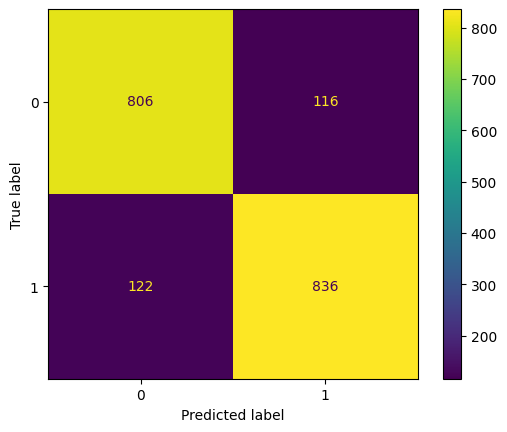

In [23]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [24]:
def create_hospital_data(file_path, hospital_configs):
    """
    Create hospital datasets with specified sizes and stroke rates

    Args:
        file_path: Path to the input CSV file
        hospital_configs: List of tuples containing (hospital_size, stroke_rate) for each hospital

    Returns:
        List of pandas DataFrames for each hospital
    """
    data = pd.read_csv(file_path)

    stroke_data = data[data['stroke'] == 1]
    non_stroke_data = data[data['stroke'] == 0]

    hospital_datasets = []

    for hospital_size, stroke_rate in hospital_configs:
        stroke_count = int(hospital_size * stroke_rate)
        non_stroke_count = hospital_size - stroke_count

        hospital_stroke = stroke_data.sample(n=stroke_count, random_state=42)
        hospital_non_stroke = non_stroke_data.sample(n=non_stroke_count, random_state=42)

        hospital_data = pd.concat([hospital_stroke, hospital_non_stroke])
        hospital_datasets.append(hospital_data)

    return hospital_datasets

In [28]:
hospital_configs = [
    (3000, 0.20),  # Hospital 1: size=3000, stroke_rate=0.20
    (2700, 0.15),  # Hospital 2: size=2700, stroke_rate=0.15
    (3200, 0.10)   # Hospital 3: size=3200, stroke_rate=0.10
]

file_path = "./balanced_stroke_data.csv"
hospital_data = create_hospital_data(file_path, hospital_configs)

for i, data in enumerate(hospital_data, 1):
    print(f"Hospital {i}\n", data.describe())
    print("\n\n")

Hospital 1
                age  hypertension  heart_disease  avg_glucose_level  \
count  3000.000000   3000.000000    3000.000000        3000.000000   
mean     47.253333      0.082667       0.046667         110.227846   
std      22.840426      0.275424       0.210959          49.034773   
min       0.000000      0.000000       0.000000          55.120000   
25%      30.000000      0.000000       0.000000          77.482500   
50%      50.000000      0.000000       0.000000          93.565000   
75%      66.000000      0.000000       0.000000         120.007500   
max      82.000000      1.000000       1.000000         270.743390   

               bmi       stroke  
count  3000.000000  3000.000000  
mean     29.192880     0.200000  
std       7.548688     0.400067  
min      11.500000     0.000000  
25%      24.200000     0.000000  
50%      28.400000     0.000000  
75%      33.178893     0.000000  
max      92.000000     1.000000  



Hospital 2
                age  hypertension  he

In [29]:
# Export each hospital dataset
for i, data in enumerate(hospital_data, 1):
    data.to_csv(f'hospital_{i}_data.csv', index=False)
    print(f"Exported Hospital {i} data to hospital_{i}_data.csv")

Exported Hospital 1 data to hospital_1_data.csv
Exported Hospital 2 data to hospital_2_data.csv
Exported Hospital 3 data to hospital_3_data.csv
